# Constructing Social Networks in the Bible

### <i>Lemuel Kumarga</i>


## Problem Description

Our social circles are huge parts of our lives. They represent who we interact with, and how much we interact with them. With the digitization of communication and socialization, finding out this circle within each individual is an easier task than before. A simple glimpse into social networking sites such as Facebook and LinkedIn allows us to see who our friends are, whilst the frequency of digital communication can be used as a proxy of our closeness with them.

However, such information was not easily quantifiable in the pre-technology era. By attempting to model past lives using modern concepts, we could potentially gain further information about the past. For this project, we will use Natural Language Processing (NLP) concepts to <b>construct a social network for the bible, with the aim to depeen our understanding of the gospel.</b>


## Preliminaries

First load the necessary modules for this exercise.

In [2]:
import sys
sys.path.append('shared/')
from defaults import *

# Load All Main Modules
load({"pd":"pandas",
      "math":"math",
      "cl":"collections",
      "np":"numpy",
      "sp":"scipy",
      "re":"re",
      "mpl":"matplotlib",
      "nltk":"nltk",
      "wordcloud":"wordcloud",
      "PIL":"PIL",
      "operator":"operator"})

# Load All Submodules
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
# If you can't find the module, run nltk.download() in python
from nltk import sent_tokenize, word_tokenize

defaults()

We will also construct helper functions that will be useful later on.

In [8]:
# -------------------------------------
# Genre-Related Functions
# -------------------------------------
def __get_genre_groups():
    global _genre_group
    if "_genre_group" not in globals():
        _genre_group = bible.groupby("Genre",sort=False)
    return _genre_group

def __get_genre_colors():
    global _genre_colors
    if "_genre_colors" not in globals():
        color_pal = get_color("palette")(len(__get_genre_groups()))
        color_dict = dict()
        ind = 0
        for name, _ in __get_genre_groups():
            color_dict[name] = color_pal[ind]
            ind += 1
        _genre_colors = color_dict
    return _genre_colors

def __get_genre_legends(rev = True):
    global _genre_legends
    global _genre_legends_rev
    if "_genre_legends" not in globals():
        _genre_legends = [mpatches.Patch(color=bg_color,label="Genre")]
        for name, group in __get_genre_groups():
            legend_text = name + " (" + group.index[0]
            if (len(group.index) > 1):
                legend_text += " - " + group.index[-1]
            legend_text += ")"
            _genre_legends.append(mpatches.Patch(color=__get_genre_colors()[name], label=legend_text))
        _genre_legends_rev = _genre_legends[:0:-1]
        _genre_legends_rev.insert(0,_genre_legends[0])
    
    if rev:
        return _genre_legends_rev
    else:
        return _genre_legends

# -------------------------------------
# Word-Cloud Related Functions
# -------------------------------------
def __word_cloud(input, fig_size = (20,10), image = None, colors = None):
    
    # Step 1: If there is an image specified, we need to create a mask
    mask = None
    if (image != None):
        mask = np.array(PIL.Image.open(image))
        if (colors == "image_colors"):
            colors = wordcloud.ImageColorGenerator(mask)
    
    # Step 2: Set up default colors
    def_colors = mpl.colors.ListedColormap(get_color())
    
    # Step 3: Generate Word Cloud
    #https://stackoverflow.com/questions/43043437/wordcloud-python-with-generate-from-frequencies
    wc = wordcloud.WordCloud(height=fig_size[1]*100,
                             width=fig_size[0]*100,
                             background_color=bg_color,
                             mask = mask,
                             colormap = def_colors,
                             color_func = colors).generate_from_frequencies(input)

    # Step 4: Plot Word Cloud
    plt.figure(figsize=fig_size)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

__get_legend_separator = mpatches.Patch(color=bg_color,label="")    
    
def __get_minmax_legends(input, title, key_format = "{:.2f}"):
    output = []
    output.append(mpatches.Patch(color=bg_color,label=title))
    max_item = max(input.items(), key=operator.itemgetter(1))
    output.append(mlines.Line2D([0], [0], marker='o', color=bg_color, label="Max: " + key_format.format(max_item[1]) + " - " + max_item[0],
                      markerfacecolor=ltxt_color, markersize=20))
    min_item = min(input.items(), key=operator.itemgetter(1))
    output.append(mlines.Line2D([0], [0], marker='o', color=bg_color, label="Min: " + key_format.format(min_item[1]) + " - " + min_item[0],
                      markerfacecolor=ltxt_color, markersize=10))
    return output
    

## Exploration

### Loading the Data

For this exercise, we will be using the bible <a data-toggle="popover" title="" data-content="A collection of texts" data-original-title="Corpus">corpus</a> from <a href="https://www.kaggle.com/oswinrh/bible/data" target="_blank">Kaggle.</a> The data will be stored in abbreviated book keys, with each book containing the following attributes:

* <span class="hl">Book Name</span>: Full name of the book
* <span class="hl">Testament</span>: New (NT) or old (OT)
* <span class="hl">Genre</span>: Genre of the book
* <span class="hl">Chapters</span>: Number of chapters
* <span class="hl">Verses</span>: Total number of verses
* <span class="hl">Text</span>: The actual text of the book



In [4]:
# Get all book statistics
abb = pd.read_csv("data/key_abbreviations_english.csv")\
        .query('p == 1')[["a","b"]]\
        .rename(columns={"a" : "Key"})
ot_nt = pd.read_csv("data/key_english.csv")\
          .rename(columns={"n" : "Name", "t" : "Testament"})
genres = pd.read_csv("data/key_genre_english.csv")\
           .rename(columns={"n" : "Genre"})

# Load the main biblical text
bible = pd.read_csv("data/t_asv.csv")\
          .groupby("b", as_index=False)\
          .agg({"c": pd.Series.nunique, "v": "size", "t":" ".join})\
          .rename(columns={"c": "Chapters","v": "Verses","t": "Text"})

# Join the remaining book statistics
bible = bible.join(abb.set_index('b'), on='b')\
             .join(ot_nt.set_index('b'), on='b')\
             .join(genres.set_index('g'), on='g')\
             .drop(['b', 'g'], axis=1)\
             .set_index('Key')\
             [["Name","Testament","Genre","Chapters","Verses","Text"]]
            
# Show the first few lines
bible.head(5)

,Name,Testament,Genre,Chapters,Verses,Text
Key,,,,,,
Gen,Genesis,OT,Law,50,1533,In the beginning God created the heavens and t...
Exo,Exodus,OT,Law,40,1213,"Now these are the names of the sons of Israel,..."
Lev,Leviticus,OT,Law,27,859,"And Jehovah called unto Moses, and spake unto ..."
Num,Numbers,OT,Law,36,1288,And Jehovah spake unto Moses in the wilderness...
Deut,Deuteronomy,OT,Law,34,959,These are the words which Moses spake unto all...



### About the Data

We will also derive some language statistics from each book, mainly:

* <span class="hl">Sentences</span>: Number of sentences in each book.
* <span class="hl">Words</span>: Number of words in each book.

In [5]:
# Add Sentences and Words columns
bible["Sentences"] = pd.Series(0, index=bible.index)
bible["Words"] = pd.Series(0, index=bible.index)

# Save Tokens
sent_tokens = OrderedDict()
word_tokens = OrderedDict()

for i, r in bible[["Text"]].iterrows():
    txt = r.str.cat()
    sent_tokens[i] = sent_tokenize(txt)
    word_tokens[i] = word_tokenize(txt)
    bible.at[i,'Sentences'] = len(sent_tokens[i])
    # Remove Punctuation
    bible.at[i,'Words'] = len([w for w in word_tokens[i] if re.match('\w+',w)])

# Show
bible[["Name","Testament","Genre","Chapters","Verses","Sentences","Words"]].head(5)

,Name,Testament,Genre,Chapters,Verses,Sentences,Words
Key,,,,,,,
Gen,Genesis,OT,Law,50,1533,1756,38037
Exo,Exodus,OT,Law,40,1213,1116,32094
Lev,Leviticus,OT,Law,27,859,664,23773
Num,Numbers,OT,Law,36,1288,996,31924
Deut,Deuteronomy,OT,Law,34,959,745,27877


#### Book Length

One of the most intuitive ways to understand the books' uneven distribution is to assume that we are doing devotions of each chapter a day. Under such a scenario, we will have the following timeline:   

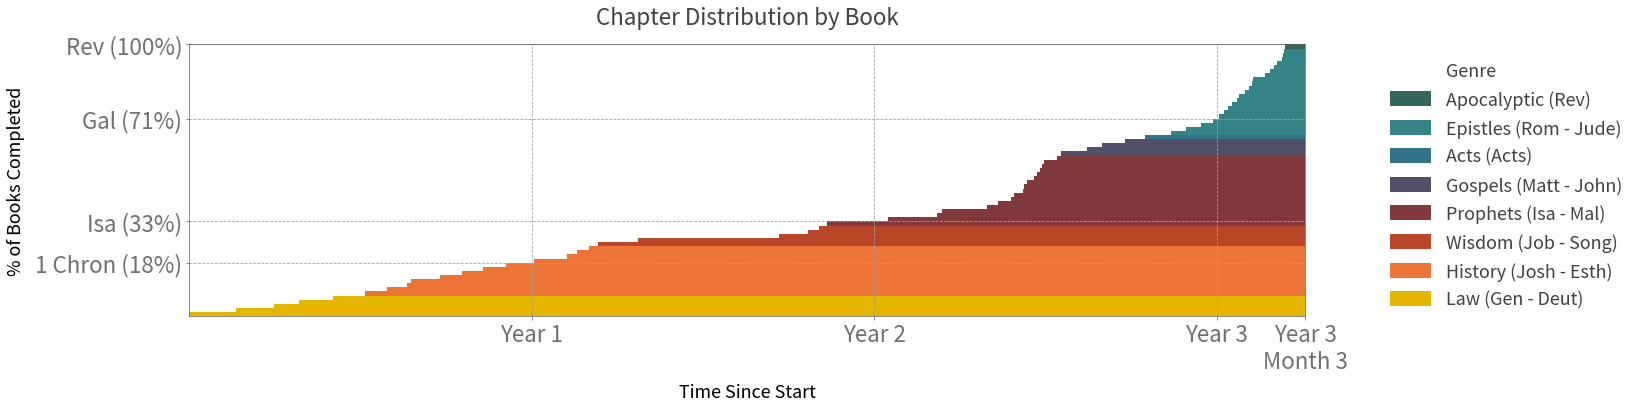

In [8]:
plt.figure(figsize=(20,5))
    
# Create Plots
yticks = []
ylabels = []
x_progress = 0
x_length = sum(bible["Chapters"])
y_progress = 0
y_length = len(bible["Chapters"])               
for name, group in __get_genre_groups():

    row_ids = [ bible.index.get_loc(i) for i in group.index ]

    # Part 1: Bars When Genre Is Still Being Read
    length = 0
    # For each book in the genre
    for idx in row_ids:

        # If we are reading this book in the anniversary 
        if (math.floor((x_progress + length)/365) < math.floor((x_progress + length + bible["Chapters"][idx])/365)):
            yticks.append(idx + 1)
            ylabels.append("{} ({}%)".format(bible.index[idx],round(idx/y_length * 100)))

        plt.broken_barh([(x_progress + length, bible["Chapters"][idx])],
                        (y_progress, (idx + 1) - y_progress),
                        facecolors = __get_genre_colors()[name])
        length += bible["Chapters"][idx]
    
    
    # Part 2: Bars When Genre has Been Read
    plt.broken_barh([(x_progress + length, x_length - x_progress - length)],
                    (y_progress, max(row_ids) + 1 - y_progress), 
                    facecolors = __get_genre_colors()[name])
    
    x_progress += length
    y_progress = max(row_ids) + 1
    

# Add Titles and Grid
plt.title("Chapter Distribution by Book")
plt.grid(color=fade_color(ltxt_color,0.5), linestyle='dashed')

# Add X-Axis Details
plt.xlabel("Time Since Start")
xticks = [365, 2 * 365, 3 * 365 ,sum(bible["Chapters"])]
xlabels = [ "Year 1", "Year 2", "Year 3", "Year 3\nMonth 3" ]
plt.xticks(xticks, xlabels)
plt.xlim(0,x_length)

# Add Y-Axis Details
yticks.append(y_length)
ylabels.append("{} ({}%)".format(bible.index[-1],round(1 * 100)))
plt.ylabel("% of Books Completed")
plt.yticks(yticks, ylabels)
plt.ylim(0, y_length)

# Add Legends
plt.legend(handles=__get_genre_legends(), bbox_to_anchor=[1.3, 1.0])

plt.show()

By the 1st year, we will have only completed 18% of the books on the bible. If this is not discouraging enough, after a further year, we would still not have completed the Old Testament (<span class="yellow-text">Law</span> to <span class="red-text">Prophets</span>). However, upon reaching the New Testament (<span class="blue-text">Gospels</span> to <span class="green-text">Apocalyptic</span>), we could complete the whole set of books within 9 months. The Old Testament is at least 3 times longer than the New Testament!

####  Chapter Length

Assuming that the average human reads <a href="http://www.readingsoft.com/" target="_blank">200 words per minute</a>, we can also estimate how long it will take to read 1 chapter every day:

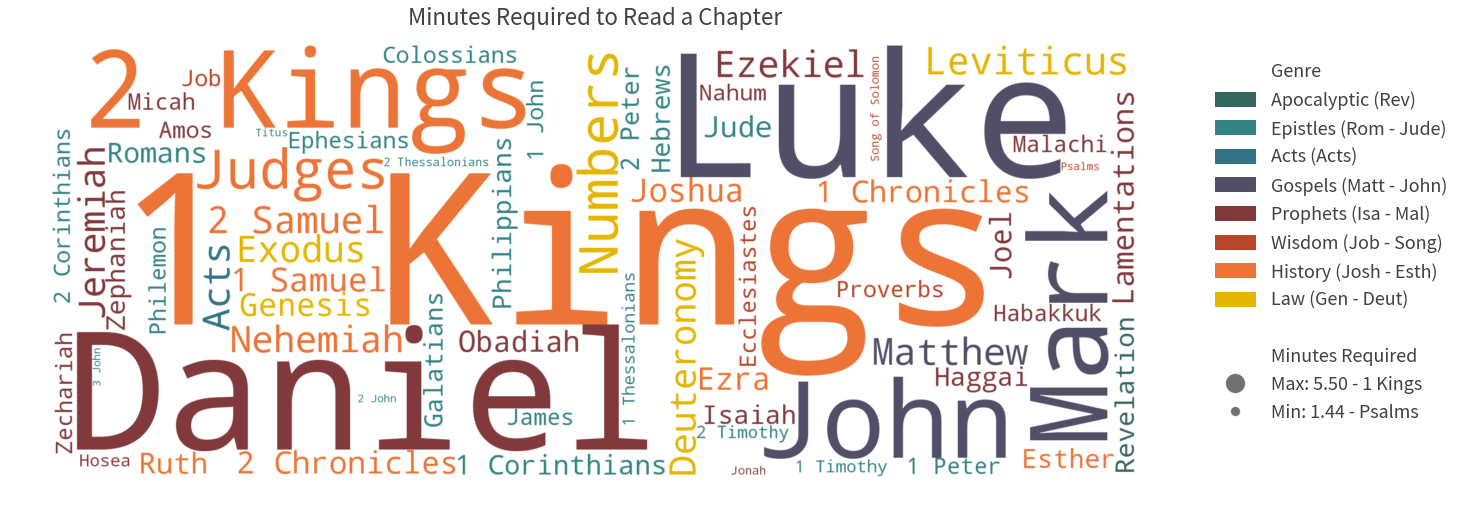

In [13]:

# 200 Words Per Minute is the Average Reading Speed
bible["Minutes_p_Chapter"] = 1. * bible["Words"] / bible["Chapters"] / 200
inputs = OrderedDict((bible['Name'][n], k) for n,k in bible["Minutes_p_Chapter"].iteritems())

# Define color functions
def color_func(word, font_size, position, orientation, **kwargs):
    return __get_genre_colors()[bible[bible["Name"] == word]["Genre"].str.cat()]

# Create Word Cloud
__word_cloud(inputs, fig_size=(20,8), colors = color_func)

# Create Title
plt.title("Minutes Required to Read a Chapter")

# Legends
legends_cloud = []
# Genre Legends
legends_cloud.extend(__get_genre_legends())
# Spacing
legends_cloud.append(__get_legend_separator)
# Min-Max Legends
legends_cloud.extend(__get_minmax_legends(inputs, "Minutes Required"))
plt.legend(handles=legends_cloud, bbox_to_anchor=[1.3, 1])

# Show Figure
plt.show()
    

From the chart above, we conclude that chapter lengths across books are varied as well. For example, a chapter in <span class="hl orange-text">1 Kings</span> will take around 5.5 minutes to read, whilst a chapter in <span class="hl red-text">Psalms</span> will take around 1.5 minutes to read. 

### Preliminary Insights

After obtaining an overview of the bible as a text, we will proceed to investigate the occurences of various characters in the bible.

#### The Trinity

The first point of interest is how much God appears at different book in the bible:


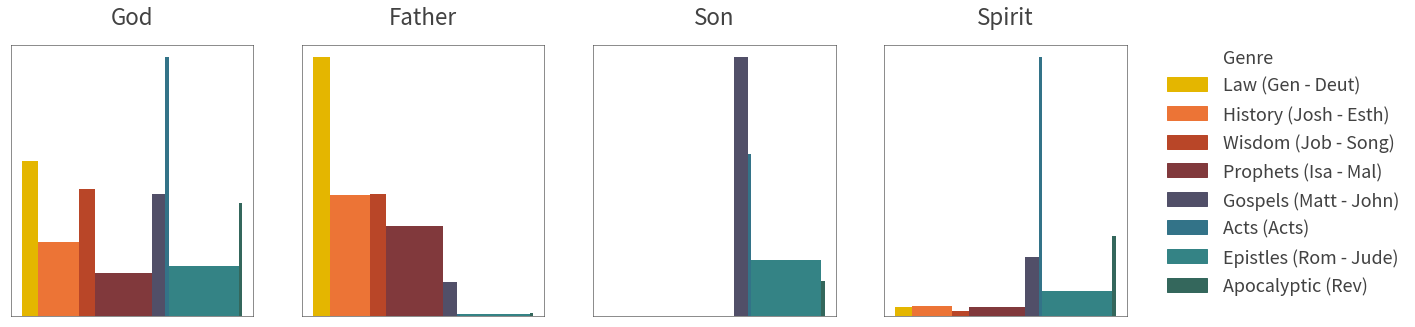

In [16]:
def find_occurence(regex):
    output = OrderedDict()
    for name, group in __get_genre_groups():
        l = [len(re.findall(regex,wt.str.cat())) for _, wt in group[["Text"]].iterrows()]
        output[name] = (len(l),sum(l)/len(l))
    return output

entityToSearch = OrderedDict([('God', 'God|Lord|GOD|LORD'),
                              ('Father','Jehovah|Father'),
                              ('Son','Jesus|Christ|Emmanuel'),
                              ('Spirit','Spirit')])

ind = 0
# Construct Plots for Each Entity
f, splt = plt.subplots(1,len(entityToSearch.items()), figsize=(20,5))
for title, regex in entityToSearch.items():
    occurences = find_occurence(regex)
    splt[ind].set_title(title)
    splt[ind].set_xticks([])
    splt[ind].set_yticks([])
    x = 0
    for n, v in occurences.items():
        splt[ind].bar([x + v[0]/2],
                      [v[1]],
                      color = __get_genre_colors()[n],
                      width = v[0])
        x += v[0]
    ind += 1

# Insert Legends
plt.legend(handles=__get_genre_legends(False), bbox_to_anchor = [2.2, 1.05])

plt.show()

Unsurprisingly, words associated with God the Father (Jehovah/Father) appears prominently in the Old Testament, while words associated with God the Son (Jesus/Christ) hits a high frequency in the Gospel narratives. Word counts of the Spirit appears the highest in Acts. This sequence is in line with the story of the Gospel, where the events first transcribed were between God the Father and His people, followed by Jesus Christ and his believers, and finally with the Holy Spirit and the church.

(Note: The limitation of such an approach is the failure to capture regular words meant to symbolize God. For example, words such as "Lamb" in Revelations correspond to Christ, but such symbols were excluded as they would introduce false positives.)

#### Major Characters

Using <a href="http://bibleblender.com/2014/biblical-lessons/biblical-history/complete-list-of-major-minor-characters-in-bible" target="_blank">external sources</a>, we can also obtain a list of the major characters in the bible. This list can then be used as a reference to detect names within the bible:

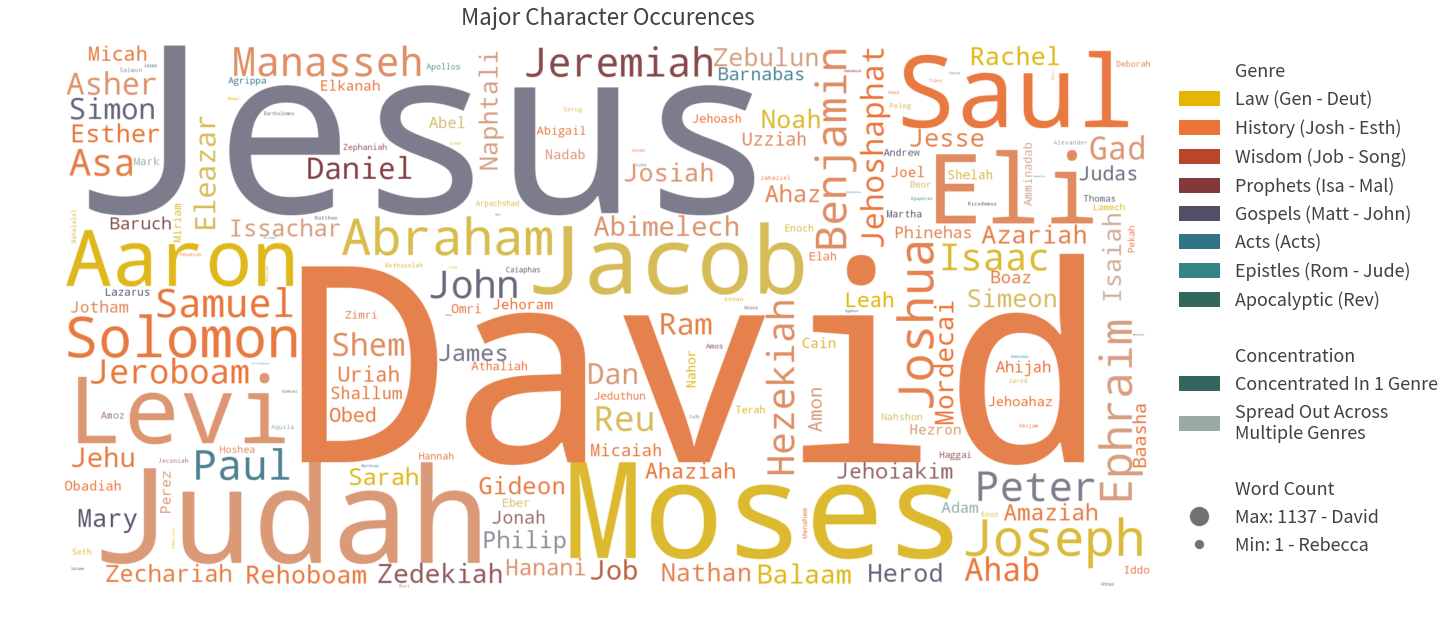

In [24]:
# Characters obtained from http://bibleblender.com/2014/biblical-lessons/biblical-history/complete-list-of-major-minor-characters-in-bible
characters_regex = 'Adam|Seth|Enos|Kenan|Mahalalel|Jared|Enoch|Methuselah|Lamech|Noah|Shem|Adam|Cain|Enoch|Irad|Mehujael|Methusael|Lamech|Tubal-cain|Arpachshad|Shelah|Eber|Peleg|Reu|Serug|Nahor|Terah|Abraham|Isaac|Jacob|Judah|Perez|Hezron|Ram|Amminadab|Nahshon|Salmon|Boaz|Obed|Jesse|David|Abel|Kenan|Enoch|Noah |Abraham|Isaac|Jacob|Joseph|Sarah|Rebecca|Rachel|Leah|Moses|Aaron|Miriam|Eldad|Medad|Phinehas|Joshua|Deborah|Gideon|Eli|Elkanah|Hannah|Abigail|Samuel|Gad|Nathan|David|Solomon|Jeduthun|Ahijah|Elijah|Elisha|Shemaiah|Iddo|Hanani|Jehu|Micaiah|Jahaziel|Eliezer|Zechariah|Huldah|Isaiah|Jeremiah|Ezekiel|Daniel|Hosea|Joel|Amos|Obadiah|Jonah|Micah|Nahum|Habakkuk|Zephaniah|Haggai|Zechariah|Malachi|Beor|Balaam|Job|Amoz|Beeri|Baruch|Agur|Uriah|Buzi|Mordecai|Esther|Oded|Azariah|Abimelech|Saul|Ish-boseth|David|Solomon|Jeroboam|Nadab|Baasha|Elah|Zimri|Tibni|Omri|Ahab|Ahaziah|Jehoram|Jehu|Jehoahaz|Jehoash|Jeroboam|Zechariah|Shallum|Menahem|Pekahiah|Pekah|Hoshea|Rehoboam|Abijam|Asa|Jehoshaphat|Jehoram|Ahaziah|Athaliah|Jehoash|Amaziah|Uzziah|Jotham|Ahaz|Hezekiah|Manasseh|Amon|Josiah|Jehoahaz|Jehoiakim|Jeconiah|Zedekiah|Simon|John|Aristobulus|Alexander|Hyrcanus|Aristobulus|Antigonus|Herod|Herod|Herod|Philip|Salome|Agrippa|Agrippa|Simon|Aaron|Eleazar|Eli|Phinehas|Asher|Benjamin|Dan|Gad|Issachar|Joseph|Ephraim|Manasseh|Judah|Levi|Naphtali|Reuben|Simeon|Zebulun|Jesus|Mary|Joseph|James|Jude|Joses|Simon|Peter|Andrew|James|John|Philip|Bartholomew|Thomas|Matthew|James|Judas|Simon|Judas|Matthias|Paul|Barnabas|James|Jude|Caiaphas|Annas|Zechariah|Agabus|Anna|Simeon|John|Apollos|Aquila|Dionysius|Epaphras|Joseph|Lazarus|Luke|Mark|Martha|Mary|Mary|Nicodemus|Onesimus|Philemon'
character_freq = []
for name, group in __get_genre_groups():
    names = [re.findall(characters_regex,wt.str.cat()) for _, wt in group[["Text"]].iterrows()]
    l = [(w,name) for l in names for w in l]
    character_freq.extend(l)

# The frequency of each character occurence by genre
character_freq = nltk.ConditionalFreqDist(character_freq)

# Create color functions to determine the genre most associated with the character
min_color = color_intermediary(bg_color,txt_color,0.3)
def color_func(word, font_size, position, orientation, **kwargs):
    most_common_genre = character_freq[word].most_common(1)[0][0]
    intensity = 1. * character_freq[word][most_common_genre] / sum(character_freq[word].values())
    return color_intermediary(min_color, __get_genre_colors()[most_common_genre],intensity)

# Plot word cloud for each name
inputs = {}
for n, fd in character_freq.items():
    inputs[n] = sum(fd.values())
__word_cloud(inputs, colors=color_func)

# Titles
plt.title("Major Character Occurences")

# Legends
legend_cloud = list(__get_genre_legends(False))
legend_cloud.append(__get_legend_separator)
def get_saturate_legends(title):
    output = []
    output.append(mpatches.Patch(color=bg_color,label=title))
    output.append(mpatches.Patch(color=get_color(0),label="Concentrated In 1 Genre"))
    output.append(mpatches.Patch(color=color_intermediary(min_color,get_color(0),0.3), label="Spread Out Across\nMultiple Genres"))
    return output
legend_cloud.extend(get_saturate_legends("Concentration"))
legend_cloud.append(__get_legend_separator)
legend_cloud.extend(__get_minmax_legends(inputs, "Word Count","{:d}"))
plt.legend(handles=legend_cloud, bbox_to_anchor = [1.28, 1.])
plt.show()



Based on the list, we conclude that <span class="hl orange-text">David</span> appears the most in the bible. In addition, his appearances seem to be concentrated within the <span class="hl orange-text">History</span> genre. This is in stark-contrast to <span class="hl">Jesus</span>, whose name appeared across multiple genres (in particular across the New Testament).

(Note: One limitation of this approach is the assumption that there is a 1-1 mapping for most names to the person. To improve the accuracy of the results, we would need to perform some name disambiguation - i.e. Does Saul refer to King Saul or Paul aka Saul? Does John refer to the disciple or the Baptist?. Unfortunately, such analysis are not within the scope of this project.) 

## Preparation

### Finding the Characters

### Cleaning Up the Errors

### Insights

## Constructing the Network

### Building Networks and Edges

### The Social Network

### Network Slices

## Summary of Results